In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

### EI test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(8, 4) (8, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 963.37it/s, 15 steps of size 2.11e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 2.67s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      2.63      3.51      1.12      0.02      7.04     44.95      0.99
_kernel_inv_length_sq[1]     35.21    110.94      8.39      0.05     42.33     36.39      1.00
_kernel_inv_length_sq[2]      2.16      4.44      0.72      0.01      5.57     40.84      0.98
_kernel_inv_length_sq[3]     37.30     73.75      1.40      0.03    126.02     44.41      1.10
        kernel_length[0]      1.89      1.71      1.38      0.72      3.51     33.47      1.04
        kernel_length[1]      1.11      1.38      0.56      0.11      2.73     39.71      0.97
        kernel_length[2]      3.83      5.48      2.17      0.24     10.27     38.56      0.97
        kernel_length[3]      1.71      1.85      1.01      0.05      4.43     64.84      1.00
            kernel_tausq      0.91      1.36      0.30      0.05      2.91     19.54      0.99
              kernel_var      9.26      8.33     

Text(0, 0.5, '$x_4$')

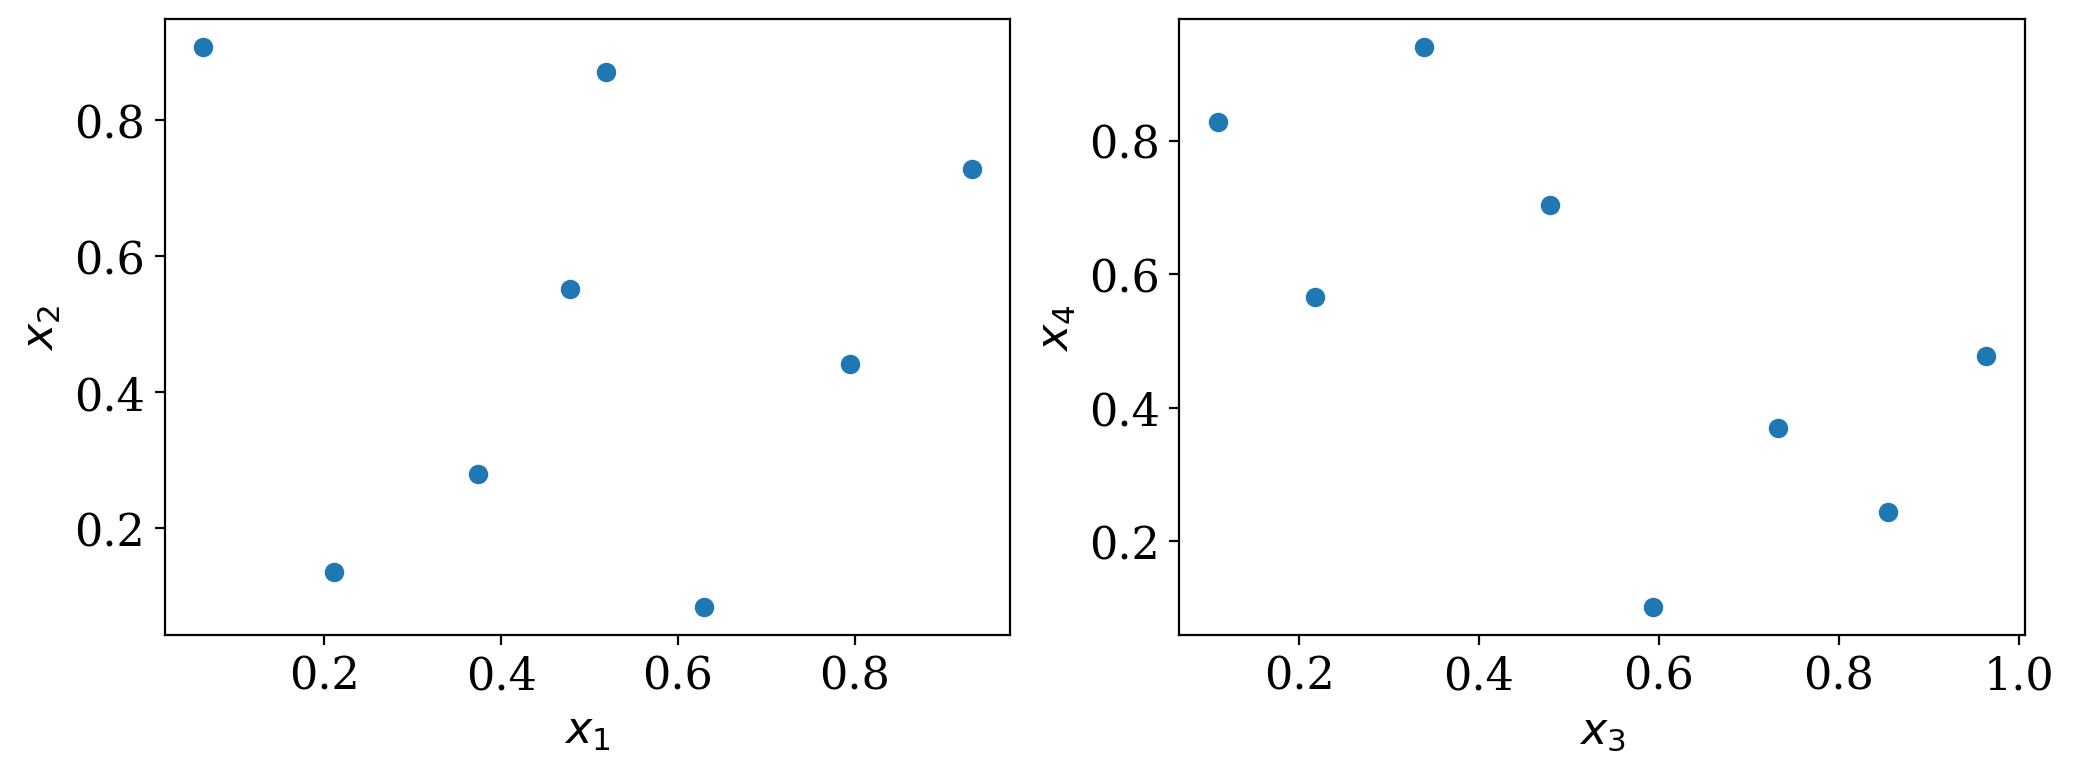

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [3]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    acq_func = EI(gp,gp.train_y.max()) # IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    gp = saas_fbgp(train_x,train_y,noise=1e-6)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 3.80s
INFO:[NS]: jaxns did 14333 likelihood evaluations


LogZ info :logz_mean: = 2.1558, dlogz: = 0.2595, 


INFO:[AQ]: Acquisition optimization took 2.61 s


Next point at x = [0.         1.         0.62579602 0.        ] with acquisition function value = -0.47554375259545634


sample: 100%|██████████| 512/512 [00:00<00:00, 678.30it/s, 15 steps of size 3.37e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 1.16s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.64s
INFO:[NS]: jaxns did 19598 likelihood evaluations


LogZ info :logz_mean: = 1.1355, dlogz: = 0.2662, 


INFO:[AQ]: Acquisition optimization took 4.76 s


Next point at x = [0.30785043 1.         1.         1.        ] with acquisition function value = -0.5667353324773183


sample: 100%|██████████| 512/512 [00:00<00:00, 659.72it/s, 15 steps of size 2.37e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 1.12s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.50s
INFO:[NS]: jaxns did 28752 likelihood evaluations


LogZ info :logz_mean: = -2.6172, dlogz: = 0.2688, 


INFO:[AQ]: Acquisition optimization took 2.41 s


Next point at x = [1.         0.74639668 0.         0.2175887 ] with acquisition function value = -0.07937705228402933


sample: 100%|██████████| 512/512 [00:00<00:00, 539.40it/s, 15 steps of size 3.40e-01. acc. prob=0.82]
INFO:[GP]: MCMC elapsed time: 1.29s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 2.01s
INFO:[NS]: jaxns did 27141 likelihood evaluations


LogZ info :logz_mean: = -1.3945, dlogz: = 0.2675, 


INFO:[AQ]: Acquisition optimization took 3.26 s


Next point at x = [0.50754182 0.68305993 1.         0.54565832] with acquisition function value = -0.09536547842135384


sample: 100%|██████████| 512/512 [00:00<00:00, 645.61it/s, 23 steps of size 3.17e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 1.14s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 1.97s
INFO:[NS]: jaxns did 26144 likelihood evaluations


LogZ info :logz_mean: = -1.5805, dlogz: = 0.2657, 


INFO:[AQ]: Acquisition optimization took 3.20 s


Next point at x = [0.36694994 0.97424029 0.         0.62032997] with acquisition function value = -0.19843656572169818


sample: 100%|██████████| 512/512 [00:00<00:00, 641.51it/s, 15 steps of size 2.76e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.14s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 2.24s
INFO:[NS]: jaxns did 27536 likelihood evaluations


LogZ info :logz_mean: = -1.7590, dlogz: = 0.2668, 


INFO:[AQ]: Acquisition optimization took 2.65 s


Next point at x = [0.         0.80971344 0.         1.        ] with acquisition function value = -0.044695996685156725


sample: 100%|██████████| 512/512 [00:00<00:00, 648.12it/s, 15 steps of size 3.44e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 1.13s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.05s
INFO:[NS]: jaxns did 30775 likelihood evaluations


LogZ info :logz_mean: = -1.4510, dlogz: = 0.2662, 


INFO:[AQ]: Acquisition optimization took 1.32 s


Next point at x = [1.00000000e+00 0.00000000e+00 1.00000000e+00 8.34211011e-18] with acquisition function value = -0.08919742379016238


sample: 100%|██████████| 512/512 [00:00<00:00, 621.12it/s, 15 steps of size 3.13e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.19s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 2.04s
INFO:[NS]: jaxns did 31488 likelihood evaluations


LogZ info :logz_mean: = -1.2476, dlogz: = 0.2679, 


INFO:[AQ]: Acquisition optimization took 3.52 s


Next point at x = [0.38356307 0.59814215 0.53417744 0.44418141] with acquisition function value = -0.13727181565166668


sample: 100%|██████████| 512/512 [00:00<00:00, 657.63it/s, 7 steps of size 4.79e-01. acc. prob=0.87] 
INFO:[GP]: MCMC elapsed time: 1.14s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 2.30s
INFO:[NS]: jaxns did 34396 likelihood evaluations


LogZ info :logz_mean: = -0.3605, dlogz: = 0.2731, 


INFO:[AQ]: Acquisition optimization took 2.61 s


Next point at x = [0.17486019 0.19791439 0.74555368 1.        ] with acquisition function value = -0.05838129281170286


sample: 100%|██████████| 512/512 [00:00<00:00, 617.74it/s, 15 steps of size 2.87e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 1.21s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 2.05s
INFO:[NS]: jaxns did 32947 likelihood evaluations


LogZ info :logz_mean: = -0.9418, dlogz: = 0.2817, 


INFO:[AQ]: Acquisition optimization took 4.44 s


Next point at x = [0.30495896 0.64315522 0.60822358 0.34726331] with acquisition function value = -0.0628428484253768


sample: 100%|██████████| 512/512 [00:00<00:00, 614.41it/s, 7 steps of size 4.04e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 1.22s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.03s
INFO:[NS]: jaxns did 29007 likelihood evaluations


LogZ info :logz_mean: = -0.4611, dlogz: = 0.2784, 


INFO:[AQ]: Acquisition optimization took 2.68 s


Next point at x = [0.         0.31693512 0.         0.        ] with acquisition function value = -0.0277641703286252


sample: 100%|██████████| 512/512 [00:00<00:00, 617.97it/s, 15 steps of size 2.90e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.20s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 2.34s
INFO:[NS]: jaxns did 29500 likelihood evaluations


LogZ info :logz_mean: = -0.0027, dlogz: = 0.2644, 


INFO:[AQ]: Acquisition optimization took 2.46 s


Next point at x = [1.         1.         1.         0.54170465] with acquisition function value = -0.010171647579847709


sample: 100%|██████████| 512/512 [00:00<00:00, 621.40it/s, 7 steps of size 3.63e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.21s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.18s
INFO:[NS]: jaxns did 28712 likelihood evaluations


LogZ info :logz_mean: = -0.0922, dlogz: = 0.2730, 


INFO:[AQ]: Acquisition optimization took 3.00 s


Next point at x = [0.68599767 0.         0.         0.        ] with acquisition function value = -0.0025273716020961998


sample: 100%|██████████| 512/512 [00:01<00:00, 499.71it/s, 7 steps of size 5.12e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 1.50s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 2.19s
INFO:[NS]: jaxns did 28814 likelihood evaluations


LogZ info :logz_mean: = -0.1420, dlogz: = 0.2666, 


INFO:[AQ]: Acquisition optimization took 2.17 s


Next point at x = [0.         0.46453855 0.53458383 0.40788787] with acquisition function value = -0.00031948790823610446


sample: 100%|██████████| 512/512 [00:00<00:00, 614.70it/s, 7 steps of size 6.54e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.24s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.10s
INFO:[NS]: jaxns did 29063 likelihood evaluations


LogZ info :logz_mean: = -0.0775, dlogz: = 0.2629, 


INFO:[AQ]: Acquisition optimization took 0.42 s


Next point at x = [1.         0.38912767 0.59567221 0.41461836] with acquisition function value = -6.462741162398439e-11


sample: 100%|██████████| 512/512 [00:00<00:00, 643.65it/s, 7 steps of size 6.00e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 1.53s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 2.07s
INFO:[NS]: jaxns did 29014 likelihood evaluations


LogZ info :logz_mean: = 0.0443, dlogz: = 0.2630, 


INFO:[AQ]: Acquisition optimization took 0.44 s


Next point at x = [0.         0.37570456 0.78639787 0.        ] with acquisition function value = -8.63651842132162e-08


sample: 100%|██████████| 512/512 [00:00<00:00, 660.58it/s, 7 steps of size 7.11e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.17s


----------------------Step 16 complete----------------------

BO took 103.16 s 


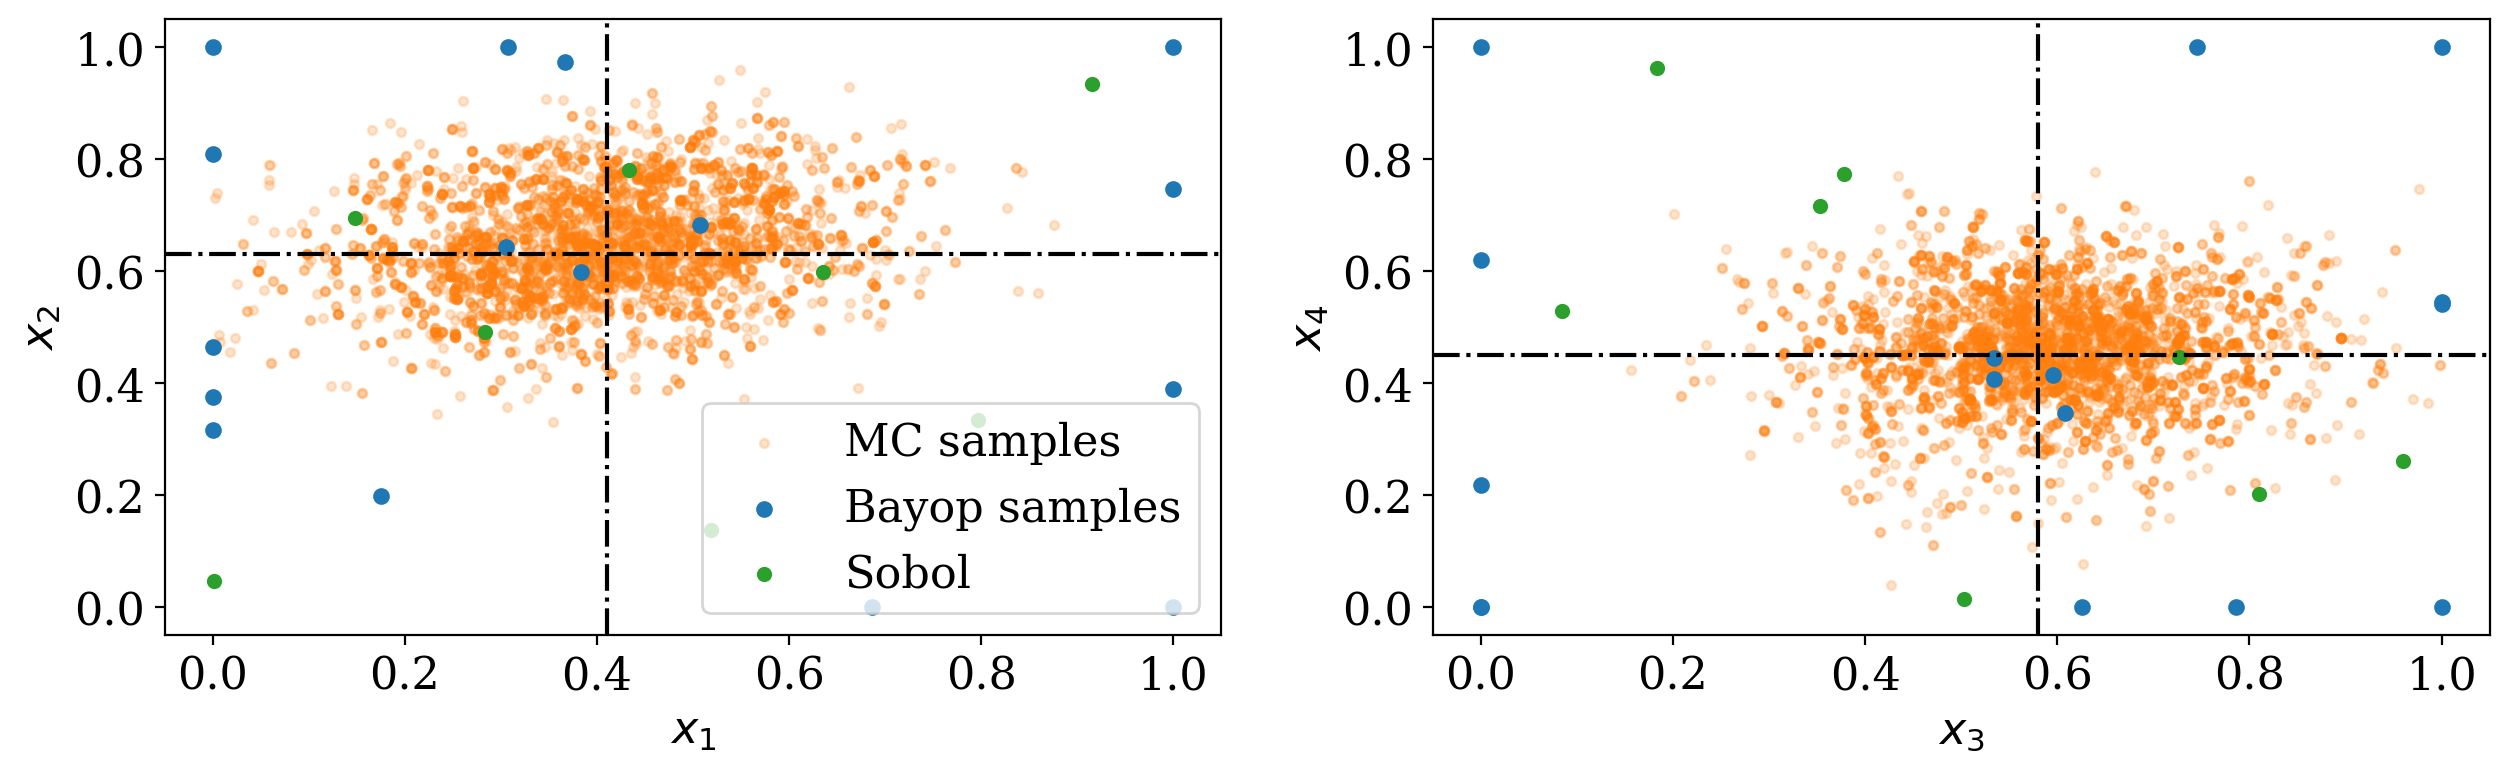

In [4]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()

In [5]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 6.79s
INFO:[NS]: jaxns did 433398 likelihood evaluations


LogZ logz_mean: -0.1092, dlogz: 0.1487, 


Removed no burn in
Removed no burn in


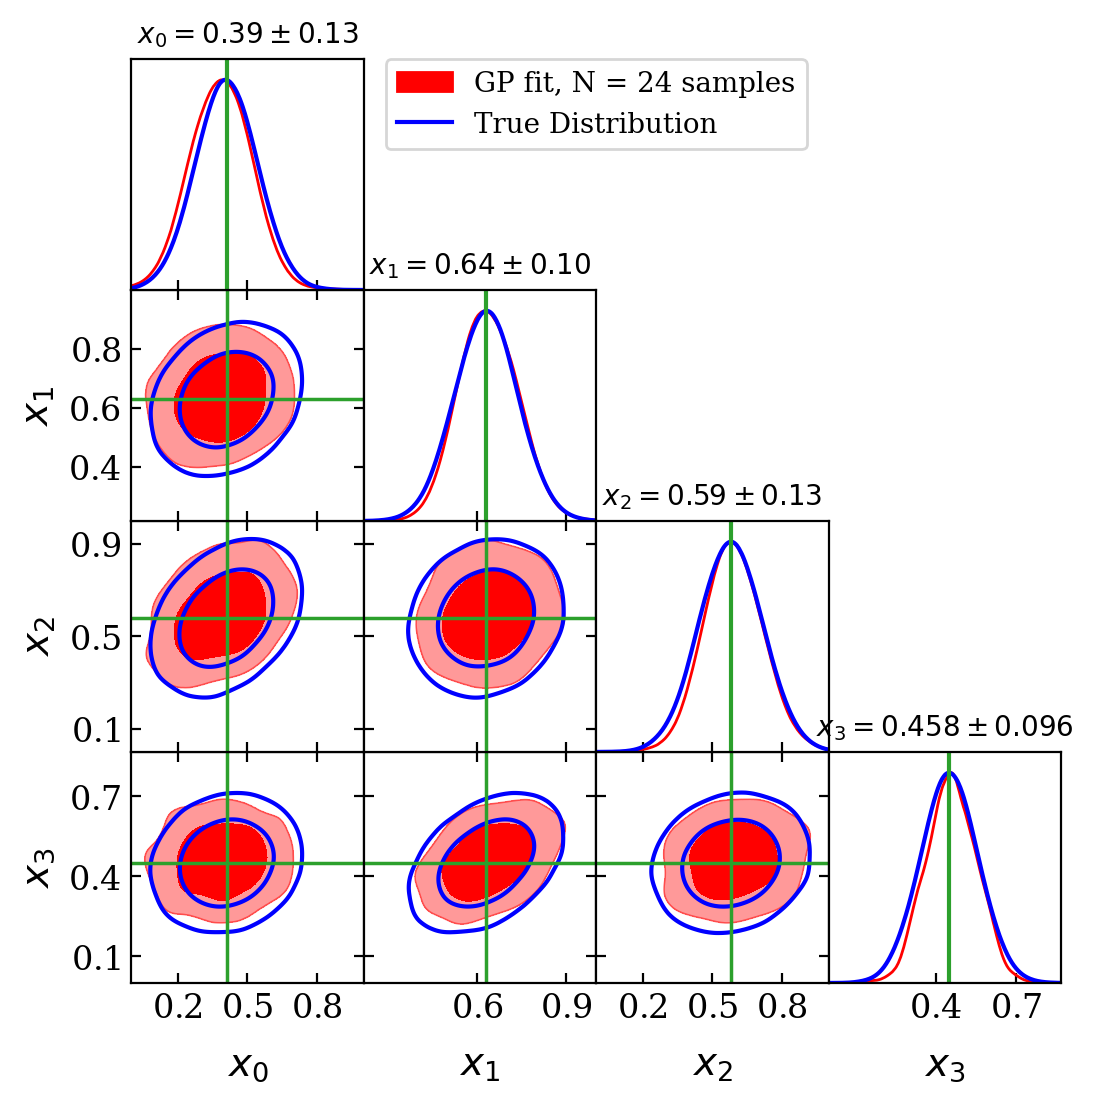

In [6]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')




### IPV test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(8, 4) (8, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 980.09it/s, 7 steps of size 3.18e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 1.16s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      2.50      5.68      0.78      0.12      3.44     27.18      0.99
_kernel_inv_length_sq[1]     70.28    160.62      6.66      0.01    208.25     44.26      0.97
_kernel_inv_length_sq[2]      7.33     21.12      1.04      0.01     11.67     39.74      1.02
_kernel_inv_length_sq[3]      2.17      2.94      0.96      0.00      6.47     37.72      1.02
        kernel_length[0]      1.76      1.48      1.35      0.19      3.90     26.99      0.98
        kernel_length[1]      0.99      2.17      0.43      0.03      1.66     40.96      0.98
        kernel_length[2]      2.26      4.66      1.15      0.15      3.92     40.89      0.99
        kernel_length[3]      2.50      2.80      1.52      0.15      7.23     27.28      0.98
            kernel_tausq      1.87      4.12      0.65      0.07      5.80     32.73      1.02
              kernel_var      7.17      6.09     

Text(0, 0.5, '$x_4$')

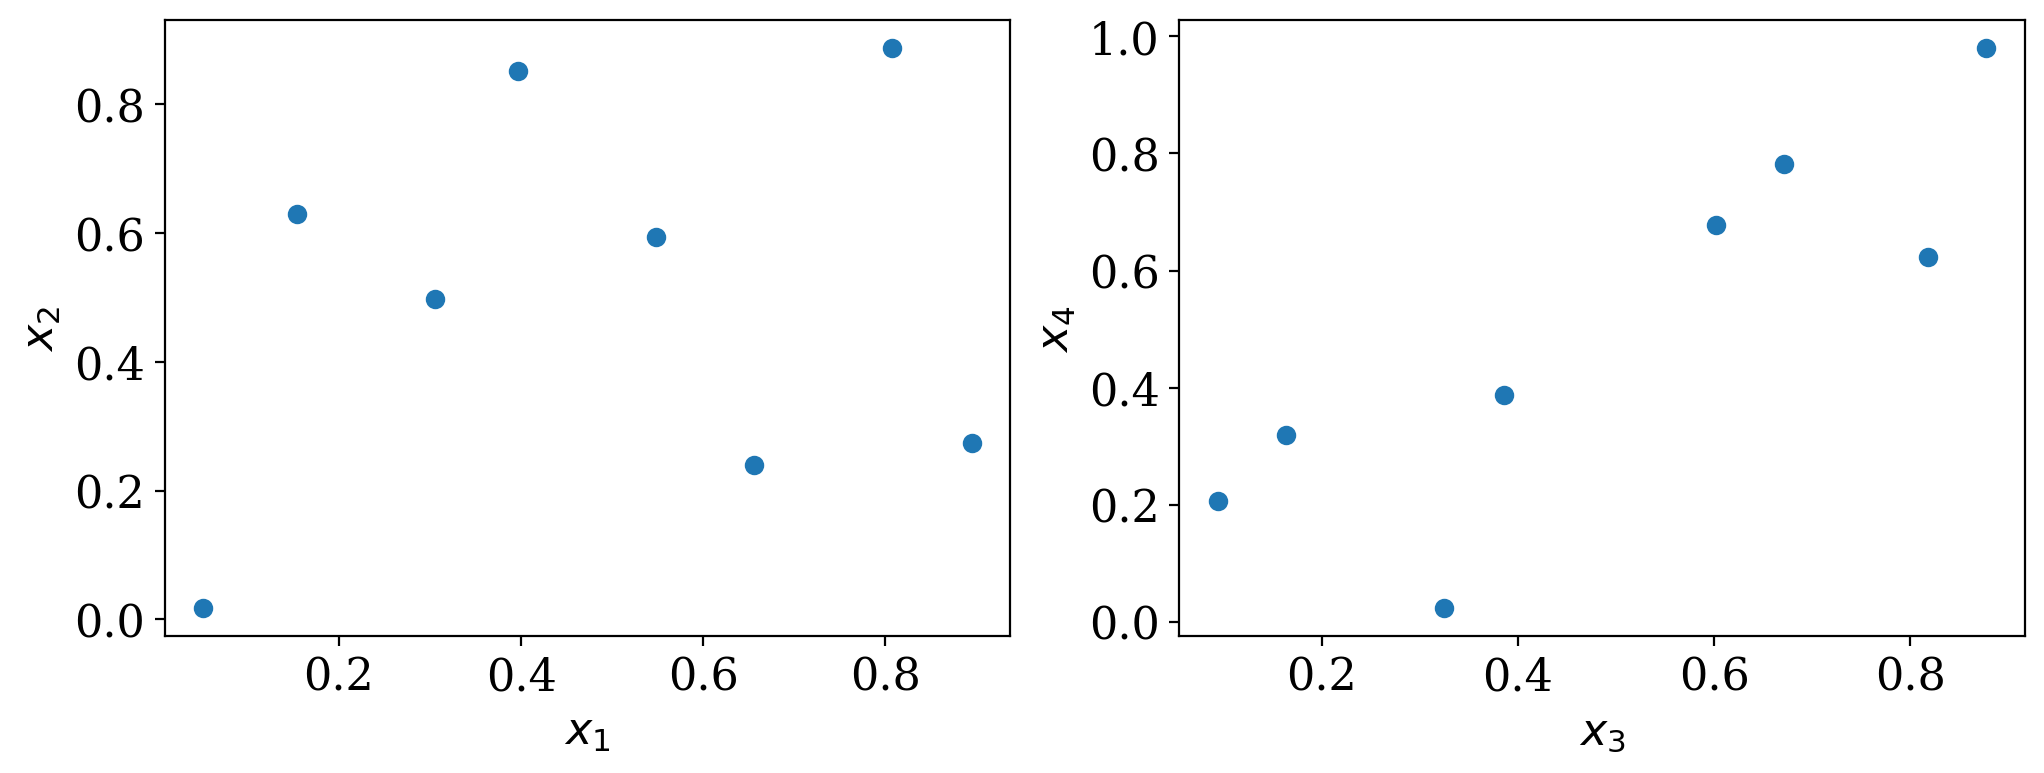

In [3]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [4]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    # print(mc_points.shape)
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.update(next_x,next_y,rng_key)
    # gp = saas_fbgp(train_x,train_y,noise=1e-6)
    # gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 3.72s
INFO:[NS]: jaxns did 17678 likelihood evaluations


LogZ info :logz_mean: = -1.8289, dlogz: = 0.2382, 


INFO:[AQ]: Acquisition optimization took 4.93 s


Next point at x = [0.15933072 0.7908282  0.56722417 0.76378873] with acquisition function value = 0.15405022398386176


sample: 100%|██████████| 384/384 [00:00<00:00, 451.88it/s, 7 steps of size 3.72e-01. acc. prob=0.80] 
INFO:[GP]: MCMC elapsed time: 1.27s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.09s
INFO:[NS]: jaxns did 20959 likelihood evaluations


LogZ info :logz_mean: = -2.0559, dlogz: = 0.2330, 


INFO:[AQ]: Acquisition optimization took 2.21 s


Next point at x = [0.23263211 0.5833195  0.78536815 0.16717986] with acquisition function value = 0.13985426949924507


sample: 100%|██████████| 384/384 [00:00<00:00, 475.14it/s, 15 steps of size 2.25e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 1.15s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.40s
INFO:[NS]: jaxns did 23332 likelihood evaluations


LogZ info :logz_mean: = -2.2277, dlogz: = 0.2226, 


INFO:[AQ]: Acquisition optimization took 2.73 s


Next point at x = [0.44748139 0.5185887  0.36301895 0.44779278] with acquisition function value = 0.13113144887644965


sample: 100%|██████████| 384/384 [00:01<00:00, 368.67it/s, 7 steps of size 2.26e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 1.41s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 2.06s
INFO:[NS]: jaxns did 28540 likelihood evaluations


LogZ info :logz_mean: = -1.2756, dlogz: = 0.2438, 


INFO:[AQ]: Acquisition optimization took 3.43 s


Next point at x = [0.76391912 0.52694902 0.14652093 0.23189921] with acquisition function value = 0.05827199764602613


sample: 100%|██████████| 384/384 [00:00<00:00, 511.15it/s, 31 steps of size 3.71e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 1.09s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.80s
INFO:[NS]: jaxns did 26648 likelihood evaluations


LogZ info :logz_mean: = -0.2185, dlogz: = 0.2601, 


INFO:[AQ]: Acquisition optimization took 2.58 s


Next point at x = [0.44874166 0.69825219 0.34459996 0.60681255] with acquisition function value = 0.026117625914053408


sample: 100%|██████████| 384/384 [00:00<00:00, 483.37it/s, 15 steps of size 2.93e-01. acc. prob=0.76]
INFO:[GP]: MCMC elapsed time: 1.17s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 2.94s
INFO:[NS]: jaxns did 30483 likelihood evaluations


LogZ info :logz_mean: = -0.9509, dlogz: = 0.2539, 


INFO:[AQ]: Acquisition optimization took 4.06 s


Next point at x = [0.5831112  0.95154151 0.65671514 0.52432368] with acquisition function value = 0.023881074832856394


sample: 100%|██████████| 384/384 [00:00<00:00, 492.99it/s, 7 steps of size 2.51e-01. acc. prob=0.96] 
INFO:[GP]: MCMC elapsed time: 1.14s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.06s
INFO:[NS]: jaxns did 26102 likelihood evaluations


LogZ info :logz_mean: = -1.2211, dlogz: = 0.2459, 


INFO:[AQ]: Acquisition optimization took 3.48 s


Next point at x = [0.38258757 0.75449517 0.57904155 0.50232217] with acquisition function value = 0.022881225379425725


sample: 100%|██████████| 384/384 [00:00<00:00, 454.68it/s, 15 steps of size 3.80e-01. acc. prob=0.83]
INFO:[GP]: MCMC elapsed time: 1.26s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 2.04s
INFO:[NS]: jaxns did 24833 likelihood evaluations


LogZ info :logz_mean: = 0.3509, dlogz: = 0.2576, 


INFO:[AQ]: Acquisition optimization took 3.09 s


Next point at x = [0.4169993  0.74439167 0.60590363 0.13984065] with acquisition function value = 0.012936207222373713


sample: 100%|██████████| 384/384 [00:01<00:00, 339.76it/s, 7 steps of size 3.07e-01. acc. prob=0.96] 
INFO:[GP]: MCMC elapsed time: 1.59s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 2.33s
INFO:[NS]: jaxns did 28802 likelihood evaluations


LogZ info :logz_mean: = -0.1945, dlogz: = 0.2648, 


INFO:[AQ]: Acquisition optimization took 4.78 s


Next point at x = [0.46259239 0.64565114 0.59995893 0.44447147] with acquisition function value = 0.007881085192543248


sample: 100%|██████████| 384/384 [00:00<00:00, 473.39it/s, 7 steps of size 3.50e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.27s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 2.36s
INFO:[NS]: jaxns did 28161 likelihood evaluations


LogZ info :logz_mean: = -0.0073, dlogz: = 0.2677, 


INFO:[AQ]: Acquisition optimization took 3.32 s


Next point at x = [0.12196333 0.65764185 0.51151514 0.45657872] with acquisition function value = 0.005155107566519181


sample: 100%|██████████| 384/384 [00:00<00:00, 442.29it/s, 1 steps of size 3.54e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 1.38s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.55s
INFO:[NS]: jaxns did 28792 likelihood evaluations


LogZ info :logz_mean: = 0.0129, dlogz: = 0.2587, 


INFO:[AQ]: Acquisition optimization took 4.57 s


Next point at x = [0.49218614 0.66677318 0.64365796 0.45660523] with acquisition function value = 0.00448999252511424


sample: 100%|██████████| 384/384 [00:00<00:00, 431.73it/s, 7 steps of size 4.74e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 1.38s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 3.10s
INFO:[NS]: jaxns did 28843 likelihood evaluations


LogZ info :logz_mean: = -0.1011, dlogz: = 0.2665, 


INFO:[AQ]: Acquisition optimization took 5.65 s


Next point at x = [0.41401405 0.52462534 0.74255969 0.457424  ] with acquisition function value = 0.0012126377846701716


sample: 100%|██████████| 384/384 [00:00<00:00, 424.76it/s, 7 steps of size 6.47e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.39s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.50s
INFO:[NS]: jaxns did 28334 likelihood evaluations


LogZ info :logz_mean: = -0.0391, dlogz: = 0.2604, 


INFO:[AQ]: Acquisition optimization took 6.19 s


Next point at x = [0.23178411 0.46764002 0.73509484 0.42742246] with acquisition function value = 0.0014223101587288282


sample: 100%|██████████| 384/384 [00:00<00:00, 453.54it/s, 7 steps of size 6.26e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.40s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 2.74s
INFO:[NS]: jaxns did 26867 likelihood evaluations


LogZ info :logz_mean: = 0.1727, dlogz: = 0.2643, 


INFO:[AQ]: Acquisition optimization took 6.54 s


Next point at x = [0.52803541 0.62328341 0.61473537 0.46503767] with acquisition function value = 0.00043276197641622244


sample: 100%|██████████| 384/384 [00:00<00:00, 414.44it/s, 7 steps of size 6.27e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.46s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.73s
INFO:[NS]: jaxns did 28716 likelihood evaluations


LogZ info :logz_mean: = 0.0422, dlogz: = 0.2566, 


INFO:[AQ]: Acquisition optimization took 4.02 s


Next point at x = [0.24350142 0.45709853 0.32546464 0.47136302] with acquisition function value = 0.0002790835961607972


sample: 100%|██████████| 384/384 [00:00<00:00, 414.52it/s, 7 steps of size 5.64e-01. acc. prob=0.95]
INFO:[GP]: MCMC elapsed time: 1.43s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 2.68s
INFO:[NS]: jaxns did 29166 likelihood evaluations


LogZ info :logz_mean: = -0.0757, dlogz: = 0.2614, 


INFO:[AQ]: Acquisition optimization took 4.06 s


Next point at x = [0.39154766 0.82488782 0.79718819 0.43548213] with acquisition function value = 0.00030256924610644505


sample: 100%|██████████| 384/384 [00:00<00:00, 412.00it/s, 3 steps of size 6.54e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.46s


----------------------Step 16 complete----------------------

BO took 133.00 s 


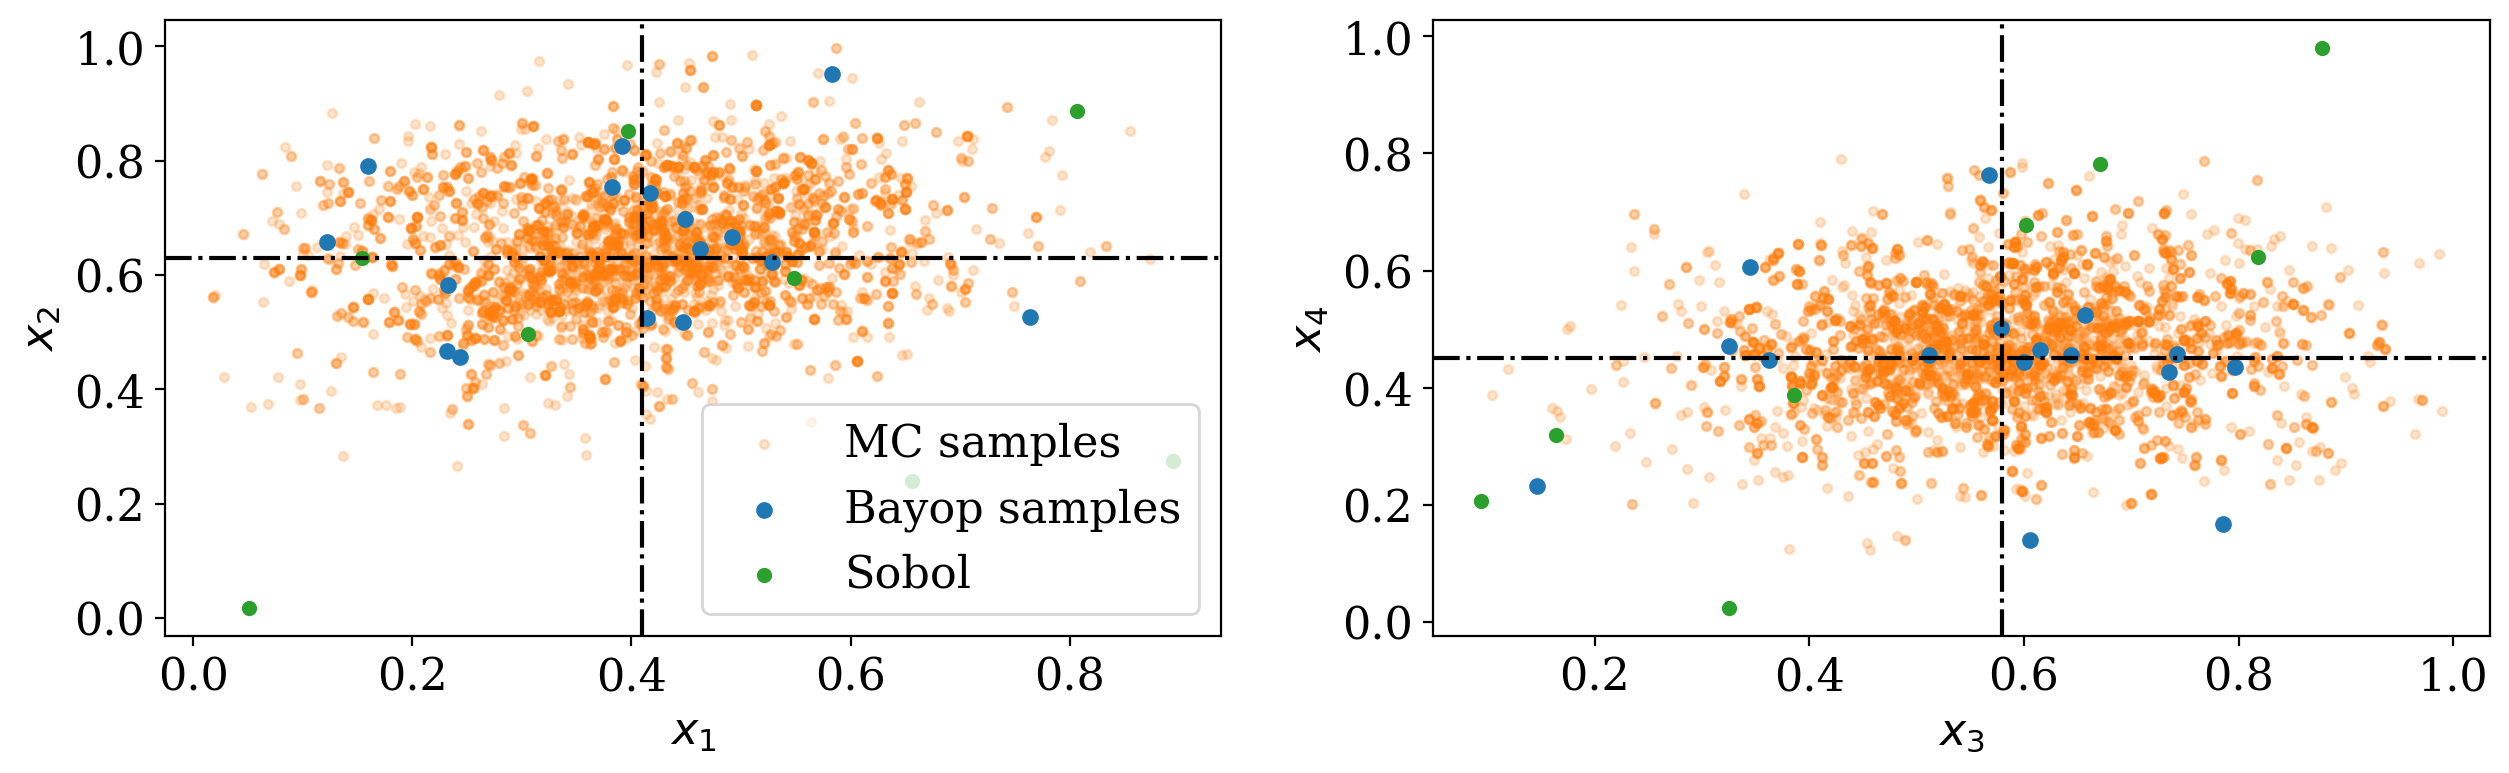

In [5]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()

In [6]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 6.66s
INFO:[NS]: jaxns did 382145 likelihood evaluations


LogZ info: logz_mean: = 0.0690, dlogz: = 0.1456, 


Removed no burn in
Removed no burn in


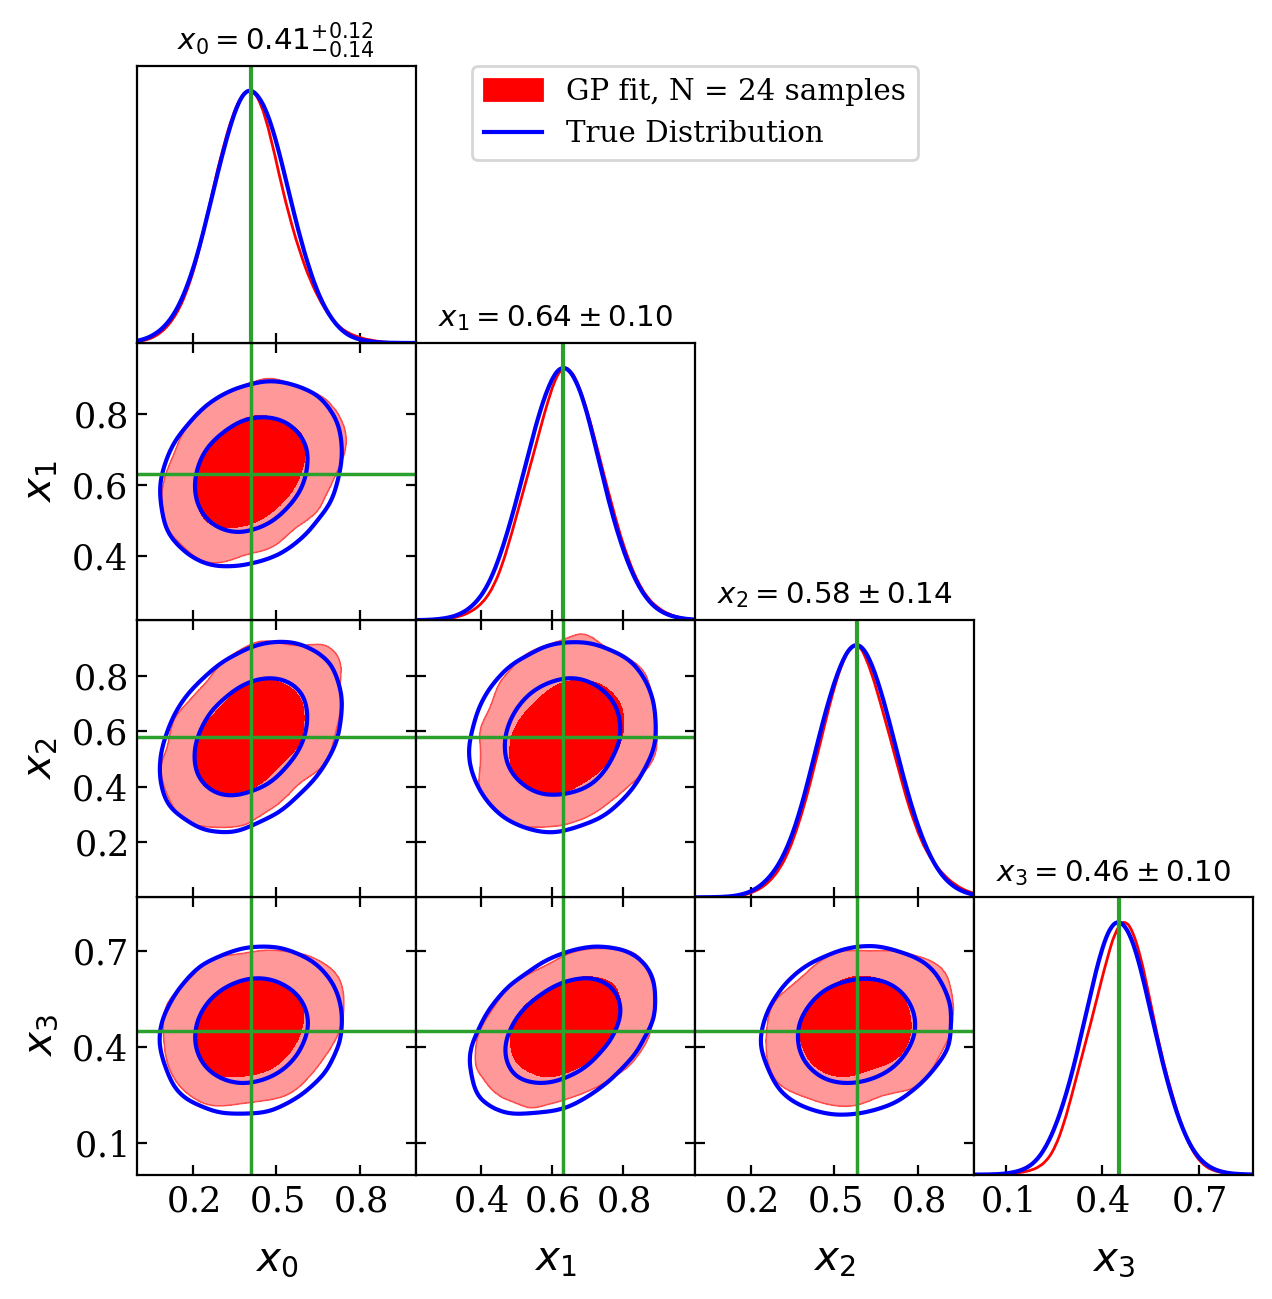

In [7]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.8,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')

# for ax in g.subplots[:,0]:
#     ax.axvline(, color='C2', ls='-')
# IPython.display.display(g.fig)

